<a href="https://colab.research.google.com/github/elsa9421/Interactive-IPython-Demos/blob/main/Robust_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Robust Regression


This notebook implements Iterative Reweighted Least Squares (IRLS) for Linear Regression data with outliers for the following losses in order to achieve **Robust Regression**
1. Convex Robust Loss : Huber
2. Nonconvex Loss: Hampel


In both cases the weights have been initialised with  Ordinary Least Squares Solution i.e Squared Error loss( nonrobust)

## Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.linear_model import HuberRegressor
from IPython import display

from ipywidgets import interact,interactive,interactive_output, fixed, interact_manual
import ipywidgets as widgets

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Linear Regression Data with outliers

The following block of code generates 1-D Linear Regression Datapoints with python library `sklearn.datasets.make_regression` and manually adds four outliers to the dataset.
The `True line` and `Squared Error loss` i.e OLS soln have been plotted. 

The closed form solution was implemented for OLS
>> $w_*$= $(X^T X)^{-1} X^T y$


Coefficients for true line : B[0]=100 , B[1]=29.614


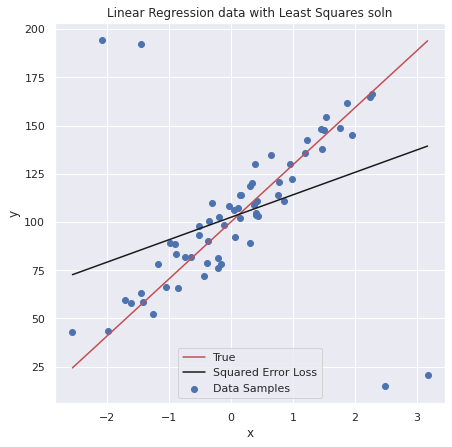

In [ ]:


# Generate toy data.
rng = np.random.RandomState(0)
X, y,coef = make_regression(n_samples=60, n_features=1, random_state=0, noise=10.0,
                       bias=100.0,coef=True)
x=X.copy()


# Add four strong outliers to the dataset.
X_outliers = rng.normal(0, 0.5, size=(4, 1))
y_outliers = rng.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + X.mean() / 4.

X_outliers[2:, :] += X.min() - X.mean() / 4.
y_outliers[:2] += y.min() - y.mean()/4
y_outliers[2:] += y.max() + y.mean()/4

X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))


x_line=np.linspace(X[:,0].min(),X[:,0].max())     # Test data points
y_true = coef*x_line+100                          # predicted values for Test data points with (The true line)




sns.set()

plt.figure(figsize=(7,7))


plt.scatter(X,y,marker='o',label="Data Samples")
plt.plot(x_line,y_true,'r',label='True')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Linear Regression data with Least Squares soln")
plt.legend()

#------------------------------------------------------------------------------

#Squared Error (nonrobust) for reference
# Implementing closed form solution
X=np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
w_star=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,y))

x_line=np.linspace(X[:,1].min(),X[:,1].max())       #test data points
y_line=w_star[1]*x_line+w_star[0]
plt.plot(x_line,y_line,'k',label='Squared Error Loss')
plt.legend()

#-----------------------------------------------------------------------------

print("Coefficients for true line : B[0]={} , B[1]={}".format(100,np.round(coef,3)))


## Iterative Reweighted Least Squares Algorithm:

1. Initialize weights, $w_i$ = 1
2. Perform Weighted Linear Regression
>> $B= (X^T W X)^{-1} (X^T W y)$
<br> where, $W$ is a diagonal matrix with $w_i$ along the diagonal
<br>When $w_i$=1 for all $i$, $B$=Ordinary Least Squares Solution
3. Calculate Residuals $r=y-\hat y$ , where $\hat y$ is obtained from $B$ calculate from step 2
4. Calculate weights as a function of residual according to loss selected
> * Huber :  
\begin{equation}
w_{Huber}(r)=\left(\begin {array}{ccc}
1, & |r|\leq k\\
k \div |r|, & |r|>k\\
\end{array} \right)
\end{equation}
>* Hampel :
\begin{equation}
w_{Hampel}(r)=\left(\begin {array}{ccc}
1, & |r|\leq a\\
a \div |r|, & a <|r|\leq b\\
a(c-|r|) \div (c-b)|r|, & b <|r|\leq c\\
0, & |r|> c\\
\end{array} \right)
\end{equation}
5. Repeat from step 2, until convergence



## Animation - All Iterations till convergence

In [ ]:
## Iterative Reweighted Least Squares
def IRLS(X=X,y=y,maxiter=100,loss="Huber"):
  

  n,p = X.shape

  # Inititalize the weights with Linear regression soln
  w = np.repeat(1., n)   #(n,)
  W = np.diag( w )      #(n,n)
  B = np.dot( np.linalg.inv( X.T.dot(W).dot(X) ), 
        ( X.T.dot(W).dot(y) ) )         #(2,)
  w_star=B

  #---------------------------------------------------
  plt.figure(figsize=(7,7))
  x_line=np.linspace(X[:,1].min(),X[:,1].max())       #test data points
  y_line_ls=w_star[1]*x_line+w_star[0]


  # huber = HuberRegressor().fit(X[:,1].reshape(-1,1), y)
  # coef_ = huber.coef_ * x_line + huber.intercept_

  if loss=="Squared Error":
    plt.figure(figsize=(7,7))
    plt.scatter(X[:,1],y,marker='o',label="Data Samples")
    plt.plot(x_line,y_true,'r',label='True')
    plt.plot(x_line,y_line_ls,'g',linestyle='--',label='Squared Error Loss')
    #plt.plot(x_line, coef_,'k',label="huber loss inbuilt fn")

    
    plt.title('{} loss; B[0]={},B[1]={}'.format(loss,round(B[0],2),round(B[1],2)), fontsize=14)

  else:
    #---------------------------------------------------
    # Parameters for Huber
    k=1.345

    # Parameters for Hampel
    # a=2
    # b= 4
    # c = 8
    a=1.7
    b=3.4 
    c=8.5

    for _ in range(maxiter):
      B_old=B.copy()
      #---------------------------Plot------------------------------------------
      plt.clf()
      plt.cla()
      plt.close()
      plt.figure(figsize=(7,7))



      plt.scatter(X[:,1],y,marker='o',label="Data Samples")
      plt.plot(x_line,y_true,'r',label='True')
      plt.plot(x_line,y_line_ls,'g',linestyle='--',label='Squared Error loss')
      #plt.plot(x_line, coef_,'k',label="huber loss inbuilt fn")

      
      plt.title('{} Loss; Iter={},B[0]={},B[1]={}'.format(loss,_+1,round(B[0],2),round(B[1],2)), fontsize=14)
          
      y_line=B[1]*x_line+B[0]
      plt.plot(x_line,y_line,'k',label="Robust loss")
      plt.xlabel('x')
      plt.ylabel('y')
      plt.legend()
          
      display.display(plt.gcf())
      display.clear_output(wait=True)

      #---------------------------end Plot----------------------------------------
      # Calculate the residual
      r=y-np.dot(X,B.T)     #residual
      abs_r=abs(r)
      

      # Compute weights according to Huber or Hampel loss
      if loss=="Huber":

        w[abs_r<=k]=1
        w[abs_r>k]=k/abs_r[abs_r>k]


      if loss=="Hampel":
        w[abs_r<=a]=1
        w[(abs_r>a) & (abs_r<=b)]=a/abs_r[(abs_r>a) & (abs_r<=b)]
        w[(abs_r>b) & (abs_r<=c)]=a*(c-abs_r[(abs_r>b) & (abs_r<=c)])/((c-b)*abs_r[(abs_r>b) & (abs_r<=c)])
        w[abs_r>c]=0


      W = np.diag( w )

      # Weighted Linear Regression
      B = np.dot( np.linalg.inv( X.T.dot(W).dot(X) ), 
          ( X.T.dot(W).dot(y) ) ) 
      
      
      if np.array_equal(np.round(B_old,2),np.round(B,2)):
        break

  if loss=="Huber"  or  loss=="Hampel":
    print("\033[1;47;40m Norm of residuals for {} loss={}".format(loss,np.linalg.norm(r)))

 
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()




#IRLS(X,y,maxiter=100,loss="Hampel")



loss_widget=widgets.Dropdown(
                      options=['Huber', 'Hampel','Squared Error'],
                      value='Squared Error',
                      description='Loss: ',
                      disabled=False
                      )



interact(IRLS,X=fixed(X),y=fixed(y),maxiter=fixed(100),loss=loss_widget)



interactive(children=(Dropdown(description='Loss: ', index=2, options=('Huber', 'Hampel', 'Squared Error'), va…

<function __main__.IRLS>